Figure 2D

By Harshaan Sekhon (sskhon2014@berkeley.edu)

Files Explained: 

1. **hg38.phyloP100way.bw** was downloaded from http://hgdownload.cse.ucsc.edu/goldenpath/hg38/phyloP100way/.
2. **hg38.phyloP20way.bw** was downloaded from http://hgdownload.cse.ucsc.edu/goldenpath/hg38/phyloP20way/.
3. **hg38.phyloP20way.bw** was downloaded from http://hgdownload.cse.ucsc.edu/goldenpath/hg38/phyloP7way/.



4. **all_eclip_peaks.txt**: ENCORE eCLIP Peak Sets were downloaded as TXT files, in the BED format. In a directory containing all TXT files, the following command line prompt was used to generate a single file: <code> cat * > all_eclip_peaks.csv </code>. The ENCORE project has provided eCLIP peak sets (called by the algorithm CLIPper.) for the following  samples on GEO: GSM2424020, GSM2423898, GSM2423163, GSM2423828, GSM2423628, GSM2424038, GSM2424172, GSM2424114, GSM2424262, GSM2423694, GSM2424161, GSM2424183, GSM2423620, GSM2423807, GSM2424043, GSM2423297, GSM2424104, GSM2422882, GSM2424102, GSM2423325, GSM2424240, GSM2423957, GSM2423193, GSM2423213, GSM2423285, GSM2423796, GSM2423906, GSM2423711, GSM2423097, GSM2423241, GSM2423451, GSM2423602, GSM2423691, GSM2424216 , GSM2422944, GSM2423480, GSM2423763, GSM2423478, GSM2424110, GSM2423509, GSM2424212, GSM2422904, GSM2423289, GSM2423152, GSM2423550,  GSM2424058, GSM2424074, GSM2422967, GSM2423143, GSM2423630, GSM2424223, GSM2423824, GSM2423270, GSM2423381, GSM2423925, GSM2423137, GSM2423274, GSM2423562, GSM2423306, GSM2423243,  GSM2424180, GSM2422937, GSM2423049, GSM2423071, GSM2423237, GSM2423548, GSM2422873, GSM2423821, GSM2423064, GSM2423475, GSM2423524, GSM2423683, GSM2423707, GSM2423584, GSM2422935, GSM2423379, GSM2423634, GSM2424062, GSM2424118, GSM2423357, GSM2423505, GSM2423222, GSM2423815, GSM2423618, GSM2424076, GSM2423817, GSM2423826. 



5. **Peak sets other than those for GCLiPP**: For all of the techniques below, first, raw sequencing reads were downloaded from the internet. Then these raw sequencing reads had were run through FastQC 0.11.9 to determine their adaptors. Then, adaptors were removed from the reads using cutadapt version 1.7.1. Then, the Cutadapt-removed sequencing reads were aligned to the GRCh38 genome assembly using bowtie2. Lastly, CLIPper 2.0 was called on this aligned sequencing file (in BAM format) to establish a list of genomic loci where each technique shows enrichment. In all instances in this paper where CLIPper 2.0 was run, it was run on completely default settings. The source of each method’s sequencing reads is stated below:

    - OOPS – Raw sequencing reads were downloaded from the European Nucleotide Archive (ENA) (https://www.ebi.ac.uk/ena/browser/view/PRJEB26736). For the 150 mJ/cm2 run, the following run accession codes label the 4 replicates within the ENA: SAMEA4663545, SAMEA4663546, SAMEA4663547, SAMEA4663548.  Raw sequencing reads were downloaded from these runs and merged into one fastq file. Then,  this fastq file was processed as stated above. For the 275 mJ/cm2 run, the following accession codes label the 4 replicates: ERR2580521, ERR2580522, ERR2580523, ERR2580524. Raw sequencing reads were downloaded from these runs and merged into one fastq file. Then,  this fastq file was processed as stated above. The resultant file used in this analysis is **275_sorted_de_dup.bed**.

    - XRNAX – Raw sequencing reads were downloaded for two conditions: (1) XRNAX w/ ribosomal RNA depleted (ERR2537872), and (2) XRNAX w/ all RNA (ERR2537875). Then,  these fastq files were separately processed as stated above. The resultant file used in this analysis is **ERR2537872_10t_sorted_picard_clipper_2.0.bed**


6. **GCLiPP_clipper_2.bed**: This file is the output from an execution of the Clipper 2.0 peak colling algoritm upon a GCLiPP experimental dataset of both stimulated and unstimulated Jurkat T Cells pooled together.

In [1]:
import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import pyBigWig
import math

In [232]:
def get_phylop(datum):
    datum = np.asarray(datum).T
    chroms = list(datum[0])
    starts= list(datum[1])
    stops= list(datum[2])
    strands= list(datum[3])
    centers = np.asarray([int(i) for i in (np.asarray(starts) + np.asarray(stops))/2])
    starts = list(centers - 100)
    stops = list(centers + 100)
    bw = pyBigWig.open(filename)
    size = len(chroms)
    b = np.asarray([0.0 for x in bw.values(chroms[0], int(starts[0])-1, int(stops[0]))])
    all_phylop = b
    count_fails = 0
    if show_tqdm:
        pbar = tqdm.tqdm(total=size)
    for i in np.arange(size):
        if show_tqdm:
            pbar.update(1)
        chrom = chroms[i]
        start = starts[i]
        stop = stops[i]
        strand = strands[i]
        try:
            a = [0.0 if math.isnan(x) else x for x in bw.values(chrom, start-1, stop)]

            if strand == "-":
                a.reverse()
            a = np.asarray(a)
            b = a + b
            a = [0 if math.isnan(x) else 1 for x in bw.values(chrom, start-1, stop)]
            if strand == "-":
                a.reverse()
            a = np.asarray(a)
            all_phylop = all_phylop + a
        except RuntimeError:
            count_fails = count_fails + 1

    all_phylop = np.asarray(all_phylop)
    y,all_phylop_lstm = np.asarray([i/j for i,j in zip(b, all_phylop)]),all_phylop
    print("Fails: " + str(count_fails))
    return y#, phyloP_list

def get_phylop_corrected(data):
    datum = np.asarray(data).T
    chroms = list(datum[0])
    starts= list(datum[1])
    stops= list(datum[2])
    strands= list(datum[3])
    centers = np.asarray([int(i) for i in (np.asarray(starts) + np.asarray(stops))/2])
    starts = list(centers - 100)
    stops = list(centers + 100)
    import pyBigWig
    bw = pyBigWig.open(filename) #GSE60034_LIB_METTL3KO_polyA_icSHAPE_reactivity.bw
    import math                                                             #GSE60034_v65polyA+icSHAPE_NAI-N3_vitro.bw
    size = len(chroms)
    b = np.asarray([0.0 for x in bw.values(chroms[0], int(starts[0])-1, int(stops[0]))])              #GSE60034_v65polyA+icSHAPE_NAI-N3_vivo.bw
    all_phylop = b
    count_fails = 0
    phyloP_list = []
    for i in (np.arange(size)):
        chrom = chroms[i]
        start = starts[i]
        stop = stops[i]
        strand = strands[i]
        try:
            data_read = bw.values(chrom, start-1, stop)
            a = [0.0 if math.isnan(x) else x for x in data_read]
            if strand == "-":
                a.reverse()
            all_phylop = all_phylop + a
            phyloP_list.append(a)
            a = [0 if math.isnan(x) else 1 for x in data_read]
            if strand == "-":
                a.reverse()
            a = np.asarray(a)
            b = a + b
        except RuntimeError:
            count_fails = count_fails + 1

    y = [i/j for i,j in zip(all_phylop,b)]
    print("Fails: " + str(count_fails))
    phyloP_list = np.asarray(phyloP_list)
    
    u = np.mean(y)
    sd = np.std(y)
    return [y, phyloP_list]


def multi_p(data):
    import time
    import multiprocess
    from multiprocess import Pool
    import tqdm
    import psutil
    start_time = time.time()
    cpu_cores = psutil.cpu_count(logical = True)
    with Pool(processes=cpu_cores,maxtasksperchild=50) as pool:
        lists = pool.map(get_phylop_corrected, np.array_split(data,cpu_cores))
    stop_time = time.time()


    pool.close()
    pool.join()
    print('Total Runtime: ' + str(round(stop_time-start_time,2)) + ' seconds')
    return lists

def normalize(arr):
    arr = (arr - np.mean(arr))/np.std(arr)
    return arr


def processing_step(data):
    phyloP_mats = [i[1] for i in data]

    phyloP_Big_mat = []

    [[phyloP_Big_mat.append(j) for j in i] for i in phyloP_mats]
    
    phyloP_avgs = [i[0] for i in data]
    avg_curve = sum(np.asarray(phyloP_avgs))/10
    
    
    phyloP_Big_mat = np.asarray(phyloP_Big_mat)
    np.random.shuffle(phyloP_Big_mat)
    
    
    phyloP_Big_mat = (phyloP_Big_mat - np.mean(avg_curve))/np.std(avg_curve)
    noram_avg_curve = (avg_curve - np.mean(avg_curve))/np.std(avg_curve)

    return noram_avg_curve, phyloP_Big_mat, avg_curve

In [233]:
sum(np.asarray([[1,2,3,4],[1,2,3,4],[1,2,3,4]]))

array([ 3,  6,  9, 12])

In [234]:
data = pd.read_csv('Resources/Clipper_Peaks/GCLiPP_clipper_2.bed', sep="\t", header=None)
gclipp_sizes = np.asarray(data[2] - data[1])
gclipp_sizes = gclipp_sizes[gclipp_sizes<200]

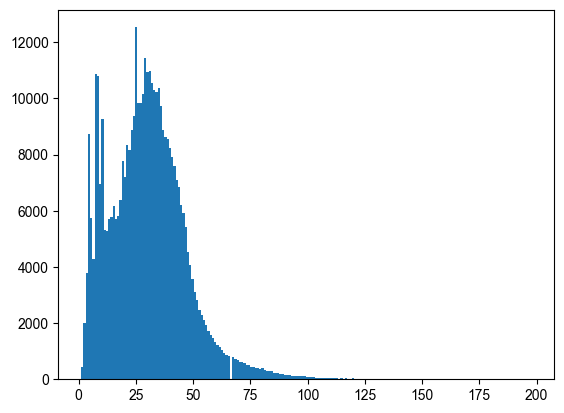

In [546]:
plt.hist(gclipp_sizes,bins=200)
plt.show()

In [236]:
data = pd.read_csv('Resources/Clipper_Peaks/ERR2537872_10t_sorted_picard_clipper_2.0.bed', sep="\t", header=None)
xrnax_sizes = np.asarray(data[2] - data[1])
xrnax_sizes = xrnax_sizes[xrnax_sizes<200]

In [237]:
data = pd.read_csv('Resources/Clipper_Peaks/275_sorted_de_dup.bed', sep="\t", header=None)
oops_sizes = np.asarray(data[2] - data[1])
oops_sizes = oops_sizes[oops_sizes<200]

0           chr14_GL000194v1_random
1           chr14_GL000194v1_random
2           chr14_GL000194v1_random
3           chr14_GL000194v1_random
4           chr14_GL000194v1_random
                     ...           
10532674                       chr5
10532675                       chr5
10532676                       chr5
10532677                       chr5
10532678                       chr5
Name: chrom, Length: 10532679, dtype: object

In [287]:
data = pd.read_csv('Resources/Clipper_Peaks/all_eclip_peaks.txt', sep="\t", header=None)
data.columns = ["chrom", "start", "stop","id", "v1", "strands", "v2", "v3", "v4", "v5"]

data = np.asarray(data['stop'] - data['start'])
ENCORE = data[data<200]

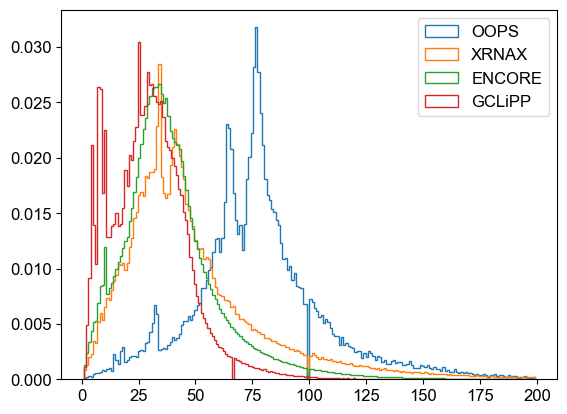

In [300]:
plt.hist(oops_sizes,bins=200, label='OOPS', density=True,histtype= 'step')

plt.hist(xrnax_sizes,bins=200, label='XRNAX', density=True,histtype= 'step')

plt.hist(ENCORE,bins=200,label='ENCORE', density=True,histtype= 'step')

plt.hist(gclipp_sizes,bins=200, label='GCLiPP', density=True,histtype= 'step')
#

plt.legend()
plt.show()

In [294]:
len(oops_sizes)

55029

In [239]:
np.std(xrnax_sizes)

31.398305191449051

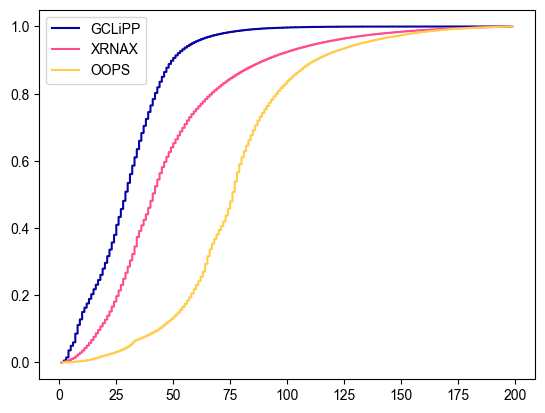

In [240]:
def CDF(data):
    # sort the data:
    data_sorted = np.sort(data)

    # calculate the proportional values of samples
    p = 1. * np.arange(len(data)) / (len(data) - 1)
    
    return data_sorted, p
x,y = CDF(gclipp_sizes)
plt.plot( x,y,label='GCLiPP',color='#0802A3')

x,y = CDF(xrnax_sizes)
plt.plot( x,y,label='XRNAX',color='#FF4B91')

x,y = CDF(oops_sizes)
plt.plot( x,y,label='OOPS',color='#FFCD4B')

plt.legend()

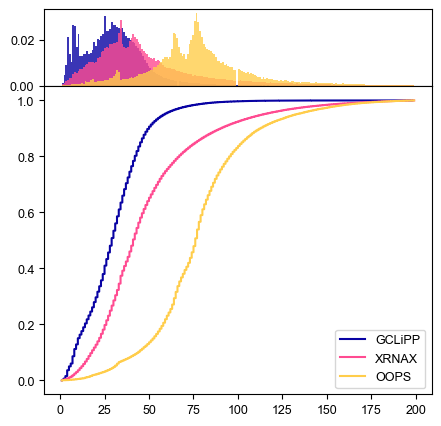

In [241]:
from matplotlib import pyplot
plt.style.use('default') 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 9
plt.rcParams["font.style"] = 'normal'
plt.rcParams["font.weight"] = 'normal'

fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(nrows=5, ncols=2,hspace=0.01)


ax_top = fig.add_subplot(gs[0, :])
ax_top.hist(gclipp_sizes,bins=200,alpha=0.8, label='GCLiPP', density=True,color='#0802A3')
ax_top.hist(xrnax_sizes,bins=200,alpha=0.8, label='XRNAX', density=True,color='#FF4B91')
ax_top.hist(oops_sizes,bins=200,alpha=0.8, label='OOPS', density=True,color='#FFCD4B')

ax_bottom = fig.add_subplot(gs[1:, :])

x,y = CDF(gclipp_sizes)
ax_bottom.plot( x,y,label='GCLiPP',color='#0802A3')

x,y = CDF(xrnax_sizes)
ax_bottom.plot( x,y,label='XRNAX',color='#FF4B91')

x,y = CDF(oops_sizes)
ax_bottom.plot( x,y,label='OOPS',color='#FFCD4B')

plt.legend()

plt.show()

In [242]:
from scipy.stats import ks_2samp

def cdf(x, xmin,xmax):
    proportion = []
    obj_len = len(x)
    for x_i in np.arange(xmin,xmax):
        proportion.append((sum(x<=x_i)/obj_len))
    return np.arange(xmin,xmax), proportion


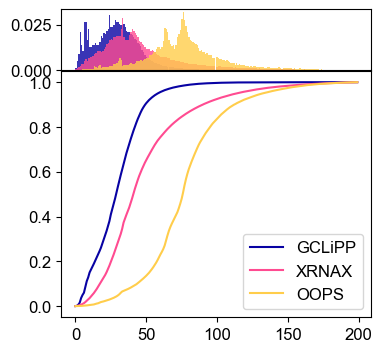

In [243]:
from matplotlib import pyplot
plt.style.use('default') 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12
plt.rcParams["font.style"] = 'normal'
plt.rcParams["font.weight"] = 'normal'

fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(nrows=5, ncols=2,hspace=0.01)


ax_top = fig.add_subplot(gs[0, :])
ax_top.hist(gclipp_sizes,bins=200,alpha=0.8, label='GCLiPP', density=True,color='#0802A3')
ax_top.hist(xrnax_sizes,bins=200,alpha=0.8, label='XRNAX', density=True,color='#FF4B91')
ax_top.hist(oops_sizes,bins=200,alpha=0.8, label='OOPS', density=True,color='#FFCD4B')

ax_bottom = fig.add_subplot(gs[1:, :])

x,y = cdf(gclipp_sizes,xmin=0,xmax=200)
ax_bottom.plot( x,y,label='GCLiPP',color='#0802A3')

x,y = cdf(xrnax_sizes,xmin=0,xmax=200)
ax_bottom.plot( x,y,label='XRNAX',color='#FF4B91')

x,y = cdf(oops_sizes,xmin=0,xmax=200)
ax_bottom.plot( x,y,label='OOPS',color='#FFCD4B')

plt.legend()
plt.savefig('plot3.pdf')

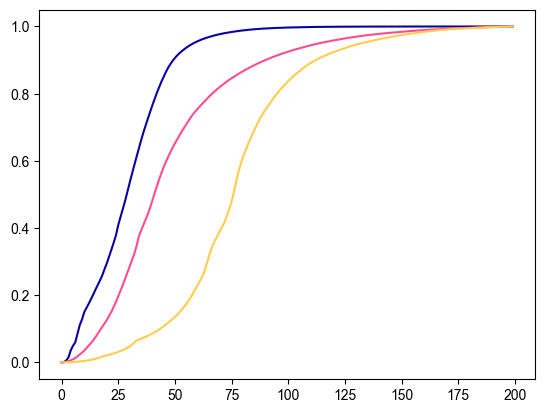

In [518]:
from scipy.stats import ks_2samp

def cdf(x, xmin,xmax):
    proportion = []
    obj_len = len(x)
    for x_i in np.arange(xmin,xmax):
        proportion.append((sum(x<=x_i)/obj_len))
    return np.arange(xmin,xmax), proportion

x,y = cdf(gclipp_sizes,xmin=0,xmax=200)
plt.plot( x,y,label='GCLiPP',color='#0802A3')

x,y = cdf(xrnax_sizes,xmin=0,xmax=200)
plt.plot( x,y,label='XRNAX',color='#FF4B91')

x,y = cdf(oops_sizes,xmin=0,xmax=200)
plt.plot( x,y,label='OOPS',color='#FFCD4B')


plt.show()

In [527]:
def CDF(data,xmin,xmax):
    # sort the data:
    data_sorted = np.sort(data)

    # calculate the proportional values of samples
    p = 1. * np.arange(len(data)) / (len(data) - 1)
    
    return data_sorted, p

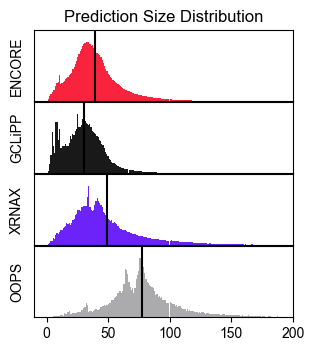

In [595]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns 
from matplotlib import pyplot
plt.style.use('default') 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 10
plt.rcParams["font.style"] = 'normal'
plt.rcParams["font.weight"] = 'normal'



#plt.hist(oops_sizes,bins=200, label='OOPS', density=True,histtype= 'step')

#plt.hist(xrnax_sizes,bins=200, label='XRNAX', density=True,histtype= 'step')

#plt.hist(ENCORE,bins=200,label='ENCORE', density=True,histtype= 'step')

#plt.hist(gclipp_sizes,bins=200, label='GCLiPP', density=True,histtype= 'step')



fig = plt.figure(figsize=(5/1.5, 7/1.5))
gs = fig.add_gridspec(nrows=10, ncols=2,hspace=0.01)

s_vmin,s_vmax = -2.5,2.5
s_cmap = 'bwr'

ax_top = fig.add_subplot(gs[:2, :])
ax_top.set_title('Prediction Size Distribution')
x,y,bar = ax_top.hist(ENCORE,bins=200,label='ENCORE', density=True,color='#FA233E',histtype='stepfilled')
ax_top.plot([np.mean(ENCORE) for i in np.linspace(0,np.max(x)*1.2 ,5)],np.linspace(0,np.max(x)*1.2 ,5),color='black')
ax_top.set_ylabel('ENCORE')

ax_top.set_yticks([]) 
ax_top.set_xticks([])
ax_top.set_xlim(-10,200)
ax_top.set_ylim(0,np.max(x)*1.2)

ax_mid = fig.add_subplot(gs[2:4, :])
x,y,bar = ax_mid.hist(gclipp_sizes,bins=200, label='GCLiPP', density=True,color='#1a1919',histtype='stepfilled')
ax_mid.plot([np.mean(gclipp_sizes) for i in np.linspace(0,np.max(x)*1.2 ,5)],np.linspace(0,np.max(x)*1.2 ,5),color='black')

ax_mid.set_ylabel('GCLiPP')

ax_mid.set_yticks([])
ax_mid.set_xticks([])
ax_mid.set_xlim(-10,200)
ax_mid.set_ylim(0,np.max(x)*1.2)


ax_last = fig.add_subplot(gs[4:6, :])
x,y,bar = ax_last.hist(xrnax_sizes,bins=200, label='XRNAX', density=True,histtype='stepfilled',color='#6b23fa',linewidth=1,linestyle='--')
ax_last.plot([np.mean(xrnax_sizes) for i in np.linspace(0,np.max(x)*1.2 ,5)],np.linspace(0,np.max(x)*1.2 ,5),color='black')
ax_last.set_ylabel('XRNAX')
ax_last.set_xlim(-10,200)
ax_last.set_ylim(0,np.max(x)*1.2)

ax_last.set_yticks([])
ax_last.set_xticks([])



ax_last = fig.add_subplot(gs[6:8, :])
ax_last.hist(oops_sizes,bins=200, label='OOPS', density=True,color='#abaaad',linewidth=0.75,linestyle=(0, (1, 1)),histtype='stepfilled')
ax_last.plot([np.mean(oops_sizes) for i in np.linspace(0,np.max(x)*1.2 ,5)],np.linspace(0,np.max(x)*1.2 ,5),color='black')
ax_last.set_ylabel('OOPS')

ax_last.set_yticks([])
ax_last.set_xticks([0,50,100,150,200])
ax_last.set_xlim(-10,200)
ax_last.set_ylim(0,np.max(x)*1.2)


#ax_right_bottom.plot(np.arange(len(eclip_avg_curve))-100 ,eclip_avg_curve ,linewidth=1,color='#FA233E',label='ENCORE')
#ax_right_bottom.plot(np.arange(len(gclipp_avg_curve))-100 ,gclipp_avg_curve ,color='black',linewidth=1,label='GCLiPP')
#ax_right_bottom.plot(np.arange(len(xrnax_avg_curve))-100 ,xrnax_avg_curve ,color='blue',linewidth=1,linestyle='--',label='XRNAX')
#ax_right_bottom.plot(np.arange(len(oops_avg_curve))-100 ,oops_avg_curve ,color='black',linewidth=0.75,linestyle=(0, (1, 1)),label='OOPS',alpha=0.5)
#ax_right_bottom.set_xlabel("position relative to center (nt.)")
#ax_right_bottom.set_ylabel("Average Normalized PhyloP")


#ax_right_bottom = fig.add_subplot(gs[8:, :])

#x,y = CDF(ENCORE,xmin=0,xmax=200)
#ax_right_bottom.plot( x,y ,linewidth=1,color='#FA233E',label='ENCORE')


#x,y = CDF(gclipp_sizes,xmin=0,xmax=200)
#ax_right_bottom.plot( x,y,color='black',linewidth=1,label='GCLiPP')

#x,y = CDF(xrnax_sizes,xmin=0,xmax=200)
#ax_right_bottom.plot( x,y,color='blue',linewidth=1,linestyle='--',label='XRNAX')

#x,y = CDF(oops_sizes,xmin=0,xmax=200)
#ax_right_bottom.plot( x,y,color='black',linewidth=0.75,linestyle=(0, (1, 1)),label='OOPS',alpha=0.5)
#ax_right_bottom.legend(fontsize=10,bbox_to_anchor=(1, 1) )
#ax_right_bottom.set_xlabel("locus size (nt.)")
#ax_right_bottom.set_ylabel("cumulative fraction")

plt.savefig('histograms_dist.pdf')

In [666]:
# ENCORE gclipp_sizes  xrnax_sizes  oops_sizes

np.mean(oops_sizes)

77.691380908248377

In [638]:
from statsmodels.stats.weightstats import ztest as ztest


In [643]:
test_stat, p = ztest(xrnax_sizes,oops_sizes)

In [667]:
test_stat, p

(-204.98299468673108, 0.0)

In [668]:
from scipy import stats

In [689]:
stats.kstest(xrnax_sizes, oops_sizes)

KstestResult(statistic=0.53583602797160257, pvalue=0.0, statistic_location=56, statistic_sign=1)

In [245]:
gclipp = pd.read_csv('Resources/Clipper_Peaks/GCLiPP_clipper_2.bed', sep="\t", header=None)
gclipp.columns = ["chrom", "start", "stop","id", "v1", "strands", "v2", "v3"]
gclipp = (gclipp[['chrom','start','stop','strands']])
gclipp = gclipp.to_numpy()

filename,show_tqdm="Resources/hg38.phyloP100way.bw",False
gclipp_p100 = multi_p(gclipp)

gclipp_avg_curve, gclipp_phyloP_Big_mat, gclipp_not_norm_avg_curve = processing_step(gclipp_p100)

Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 2
Total Runtime: 7.85 seconds


In [246]:
xrnax = pd.read_csv('Resources/Clipper_Peaks/ERR2537872_10t_sorted_picard_clipper_2.0.bed', sep="\t", header=None)
xrnax.columns = ["chrom", "start", "stop","id", "v1", "strands", "v2", "v3"]
xrnax = (xrnax[['chrom','start','stop','strands']])
xrnax = xrnax.to_numpy()

filename,show_tqdm="Resources/hg38.phyloP100way.bw",False
xrnax_p100 = multi_p(xrnax)

xrnax_avg_curve, xrnax_phyloP_Big_mat, xrnax_not_norm_avg_curve = processing_step(xrnax_p100)

Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Total Runtime: 8.21 seconds


In [247]:
oops = pd.read_csv('Resources/Clipper_Peaks/275_sorted_de_dup.bed', sep="\t", header=None)
oops.columns = ["chrom", "start", "stop","id", "v1", "strands", "v2", "v3"]
oops = (oops[['chrom','start','stop','strands']])
oops = oops.to_numpy()

filename,show_tqdm="Resources/hg38.phyloP100way.bw",False
oops_p100 = multi_p(oops)


oops_avg_curve, oops_phyloP_Big_mat, oops_not_norm_avg_curve = processing_step(oops_p100)

Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Total Runtime: 1.0 seconds


In [249]:
def processing_step_eclip(data):
    phyloP_mats = [i[1] for i in data]

    phyloP_Big_mat = []

    [[phyloP_Big_mat.append(j) for j in i] for i in phyloP_mats]
    
    phyloP_avgs = [i[0] for i in data]
    avg_curve = sum(np.asarray(phyloP_avgs))/10
    
    
    phyloP_Big_mat = np.asarray(phyloP_Big_mat)
    np.random.shuffle(phyloP_Big_mat)
    
    u = np.mean(avg_curve)
    sd = np.std(avg_curve)
    
    for i in np.arange(len(phyloP_Big_mat)):
        phyloP_Big_mat[i] = (phyloP_Big_mat[i] -u)/sd
    norm_avg_curve = (avg_curve - np.mean(avg_curve))/np.std(avg_curve)

    return norm_avg_curve, phyloP_Big_mat, avg_curve







def get_phylop_corrected_eclip(data):
    datum = np.asarray(data).T
    chroms = list(datum[0])
    starts= list(datum[1])
    stops= list(datum[2])
    strands= list(datum[3])
    centers = np.asarray([int(i) for i in (np.asarray(starts) + np.asarray(stops))/2])
    starts = list(centers - 100)
    stops = list(centers + 100)
    import pyBigWig
    bw = pyBigWig.open(filename) #GSE60034_LIB_METTL3KO_polyA_icSHAPE_reactivity.bw
    import math                                                             #GSE60034_v65polyA+icSHAPE_NAI-N3_vitro.bw
    size = len(chroms)
    b = np.asarray([0.0 for x in bw.values(chroms[0], int(starts[0])-1, int(stops[0]))])              #GSE60034_v65polyA+icSHAPE_NAI-N3_vivo.bw
    all_phylop = b
    count_fails = 0
    for i in (np.arange(size)):
        chrom = chroms[i]
        start = starts[i]
        stop = stops[i]
        strand = strands[i]
        try:
            data_read = bw.values(chrom, start-1, stop)
            a = [0.0 if math.isnan(x) else x for x in data_read]
            if strand == "-":
                a.reverse()
            all_phylop = all_phylop + a
            a = [0 if math.isnan(x) else 1 for x in data_read]
            if strand == "-":
                a.reverse()
            a = np.asarray(a)
            b = a + b
        except RuntimeError:
            count_fails = count_fails + 1

    y = [i/j for i,j in zip(all_phylop,b)]
    print("Fails: " + str(count_fails))
    
    u = np.mean(y)
    sd = np.std(y)
    return y


def multi_p_eclip(data):
    import time
    import multiprocess
    from multiprocess import Pool
    import tqdm
    import psutil
    start_time = time.time()
    cpu_cores = psutil.cpu_count(logical = True)
    with Pool(processes=cpu_cores,maxtasksperchild=50) as pool:
        lists = pool.map(get_phylop_corrected_eclip, np.array_split(data,cpu_cores))
    stop_time = time.time()


    pool.close()
    pool.join()
    print('Total Runtime: ' + str(round(stop_time-start_time,2)) + ' seconds')
    return lists


In [250]:
eclip = pd.read_csv('Resources/Clipper_Peaks/all_eclip_peaks.txt', sep="\t", header=None)
eclip.columns = ["chrom", "start", "stop","id", "v1", "strands", "v2", "v3", "v4", "v5"]
eclip = (eclip[['chrom','start','stop','strands']])
eclip = eclip.sample(10**6)
eclip = eclip.to_numpy()

filename,show_tqdm="Resources/hg38.phyloP100way.bw",False
eclip_p100 = multi_p(eclip)


eclip_avg_curve, eclip_phyloP_Big_mat, eclip_not_norm_avg_curve = processing_step_eclip(eclip_p100)

Fails: 64
Fails: 39
Fails: 50
Fails: 48
Fails: 40
Fails: 38
Fails: 50
Fails: 38
Fails: 34
Fails: 45
Total Runtime: 25.95 seconds


In [252]:
eclip = pd.read_csv('Resources/Clipper_Peaks/all_eclip_peaks.txt', sep="\t", header=None)
eclip.columns = ["chrom", "start", "stop","id", "v1", "strands", "v2", "v3", "v4", "v5"]
eclip = (eclip[['chrom','start','stop','strands']])
eclip = eclip.to_numpy()

eclip_p100 = multi_p_eclip(eclip)


Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 4399
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Total Runtime: 111.95 seconds


In [253]:
True_eclip_avg_curve = sum(np.asarray(eclip_p100))/10
eclip_not_norm_avg_curve = True_eclip_avg_curve.copy()
True_eclip_avg_curve = (True_eclip_avg_curve-np.mean(True_eclip_avg_curve))/np.std(True_eclip_avg_curve)

In [ ]:
1.15, 2.13, 0.23

In [277]:
(np.std(gclipp_not_norm_avg_curve)**2)/(np.std(eclip_not_norm_avg_curve)**2)

1.1513445249161871

In [278]:
(np.std(xrnax_not_norm_avg_curve)**2)/(np.std(eclip_not_norm_avg_curve)**2)

2.1365215061624929

In [279]:
(np.std(oops_not_norm_avg_curve)**2)/(np.std(eclip_not_norm_avg_curve)**2)

0.23273185530357013

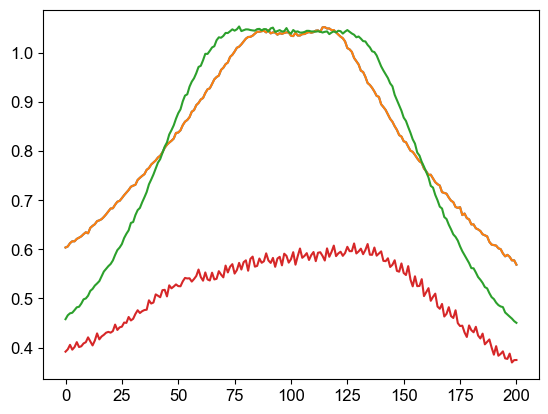

In [266]:
plt.plot(gclipp_not_norm_avg_curve)
plt.plot(gclipp_not_norm_avg_curve)
plt.plot(xrnax_not_norm_avg_curve)
plt.plot(oops_not_norm_avg_curve)

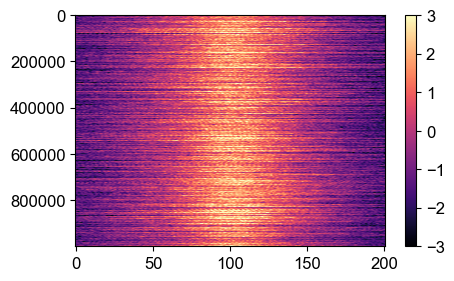

In [22]:
plt.figure(figsize=(5, 3))


plt.imshow(eclip_phyloP_Big_mat,aspect='auto',cmap='magma',vmin=-3,vmax=3,interpolation='bicubic')

plt.colorbar()
plt.savefig('colorbar.pdf')

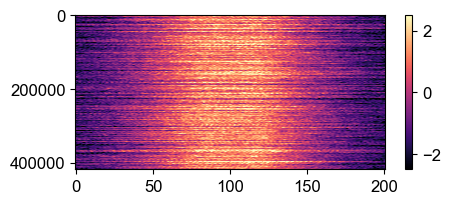

In [23]:
#from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(5, 2))


plt.imshow(gclipp_phyloP_Big_mat,aspect='auto',cmap='magma',vmin=-2.5,vmax=2.5,interpolation='bicubic')

plt.colorbar()

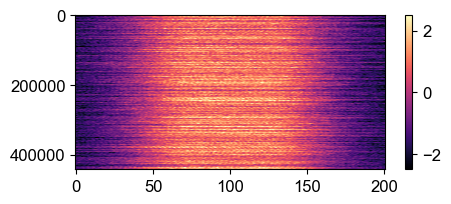

In [24]:
plt.figure(figsize=(5, 2))


plt.imshow(xrnax_phyloP_Big_mat,aspect='auto',cmap='magma',vmin=-2.5,vmax=2.5,interpolation='bicubic')

plt.colorbar()

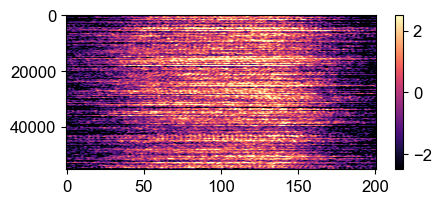

In [25]:
plt.figure(figsize=(5, 2))


plt.imshow(oops_phyloP_Big_mat,aspect='auto',cmap='magma',vmin=-2.5,vmax=2.5,interpolation='bicubic')

plt.colorbar()

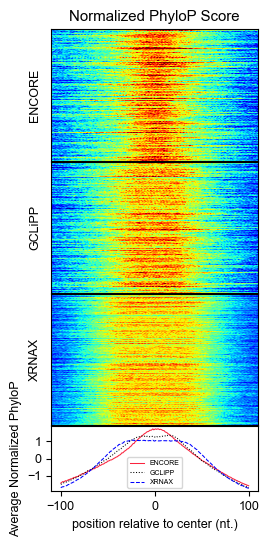

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns 
from matplotlib import pyplot
plt.style.use('default') 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 9
plt.rcParams["font.style"] = 'normal'
plt.rcParams["font.weight"] = 'normal'

fig = plt.figure(figsize=(4/1.5, 9/1.5))
gs = fig.add_gridspec(nrows=7, ncols=2,hspace=0.01)


ax_top = fig.add_subplot(gs[:2, :])
ax_top.set_title('Normalized PhyloP Score')
ax_top.imshow(eclip_phyloP_Big_mat,aspect='auto',cmap='jet',vmin=-3,vmax=3,interpolation='bicubic')
ax_top.set_ylabel('ENCORE')

ax_top.set_yticks([])
ax_top.set_xticks([])


ax_mid = fig.add_subplot(gs[2:4, :])
ax_mid.imshow(gclipp_phyloP_Big_mat,aspect='auto',cmap='jet',vmin=-3,vmax=3,interpolation='bicubic')
ax_mid.set_ylabel('GCLiPP')

ax_mid.set_yticks([])
ax_mid.set_xticks([])


ax_last = fig.add_subplot(gs[4:6, :])
ax_last.imshow(xrnax_phyloP_Big_mat,aspect='auto',cmap='jet',vmin=-3,vmax=3,interpolation='bicubic')
ax_last.set_ylabel('XRNAX')

ax_last.set_yticks([])
ax_last.set_xticks([])


ax_right_bottom = fig.add_subplot(gs[-1, :])

ax_right_bottom.plot(np.arange(len(eclip_avg_curve))-100 ,eclip_avg_curve ,linewidth=0.75,color='#FA233E',label='ENCORE')
ax_right_bottom.plot(np.arange(len(gclipp_avg_curve))-100 ,gclipp_avg_curve ,color='black',linewidth=0.75,linestyle='dotted',label='GCLiPP')
ax_right_bottom.plot(np.arange(len(xrnax_avg_curve))-100 ,xrnax_avg_curve ,color='blue',linewidth=0.75,linestyle='--',label='XRNAX')
ax_right_bottom.set_xlabel("position relative to center (nt.)")
ax_right_bottom.set_ylabel("Average Normalized PhyloP")

ax_right_bottom.set_xticks([-100,0,100])
ax_right_bottom.legend(fontsize=5)

plt.savefig('plot1.pdf')

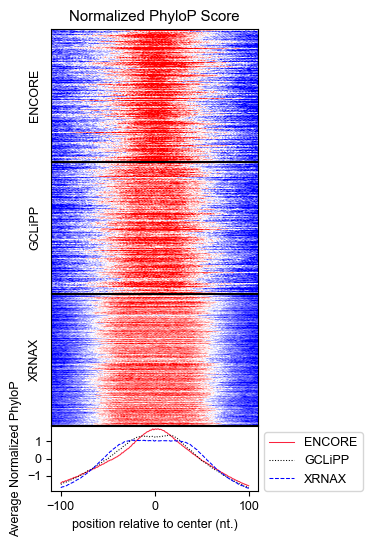

In [76]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns 
from matplotlib import pyplot
plt.style.use('default') 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 9
plt.rcParams["font.style"] = 'normal'
plt.rcParams["font.weight"] = 'normal'

fig = plt.figure(figsize=(4/1.5, 9/1.5))
gs = fig.add_gridspec(nrows=7, ncols=2,hspace=0.01)


ax_top = fig.add_subplot(gs[:2, :])
ax_top.set_title('Normalized PhyloP Score')
ax_top.imshow(eclip_phyloP_Big_mat,aspect='auto',cmap='bwr',vmin=-2,vmax=2,interpolation='bicubic')
ax_top.set_ylabel('ENCORE')

ax_top.set_yticks([])
ax_top.set_xticks([])


ax_mid = fig.add_subplot(gs[2:4, :])
ax_mid.imshow(gclipp_phyloP_Big_mat,aspect='auto',cmap='bwr',vmin=-2,vmax=2,interpolation='bicubic')
ax_mid.set_ylabel('GCLiPP')

ax_mid.set_yticks([])
ax_mid.set_xticks([])


ax_last = fig.add_subplot(gs[4:6, :])
ax_last.imshow(xrnax_phyloP_Big_mat,aspect='auto',cmap='bwr',vmin=-2,vmax=2,interpolation='bicubic')
ax_last.set_ylabel('XRNAX')

ax_last.set_yticks([])
ax_last.set_xticks([])


ax_right_bottom = fig.add_subplot(gs[-1, :])

ax_right_bottom.plot(np.arange(len(eclip_avg_curve))-100 ,eclip_avg_curve ,linewidth=0.75,color='#FA233E',label='ENCORE')
ax_right_bottom.plot(np.arange(len(gclipp_avg_curve))-100 ,gclipp_avg_curve ,color='black',linewidth=0.75,linestyle='dotted',label='GCLiPP')
ax_right_bottom.plot(np.arange(len(xrnax_avg_curve))-100 ,xrnax_avg_curve ,color='blue',linewidth=0.75,linestyle='--',label='XRNAX')
ax_right_bottom.set_xlabel("position relative to center (nt.)")
ax_right_bottom.set_ylabel("Average Normalized PhyloP")

ax_right_bottom.set_xticks([-100,0,100])
ax_right_bottom.legend(fontsize=9,bbox_to_anchor=(1, 1) )

plt.savefig('plot1.pdf')

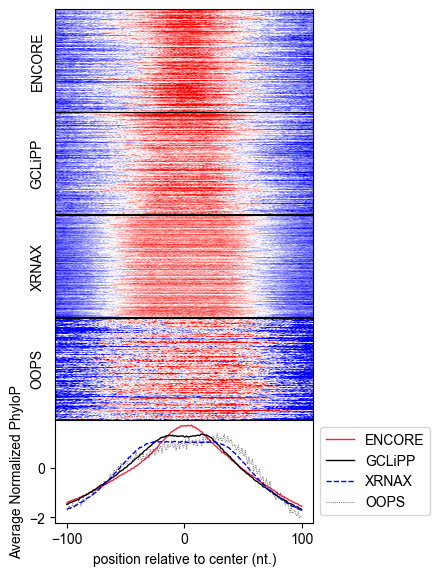

In [801]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns 
from matplotlib import pyplot
plt.style.use('default') 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 10
plt.rcParams["font.style"] = 'normal'
plt.rcParams["font.weight"] = 'normal'

fig = plt.figure(figsize=(5/1.5, 10/1.5))
gs = fig.add_gridspec(nrows=10, ncols=2,hspace=0.01)

s_vmin,s_vmax = -2.5,2.5
s_cmap = 'bwr'

ax_top = fig.add_subplot(gs[:2, :])
#ax_top.set_title('Normalized PhyloP Score')
ax_top.imshow(eclip_phyloP_Big_mat,aspect='auto',cmap=s_cmap,vmin=s_vmin,vmax=s_vmax,interpolation='bicubic')
ax_top.set_ylabel('ENCORE')

ax_top.set_yticks([])
ax_top.set_xticks([])


ax_mid = fig.add_subplot(gs[2:4, :])
ax_mid.imshow(gclipp_phyloP_Big_mat,aspect='auto',cmap=s_cmap,vmin=s_vmin,vmax=s_vmax,interpolation='bicubic')
ax_mid.set_ylabel('GCLiPP')

ax_mid.set_yticks([])
ax_mid.set_xticks([])


ax_last = fig.add_subplot(gs[4:6, :])
ax_last.imshow(xrnax_phyloP_Big_mat,aspect='auto',cmap=s_cmap,vmin=s_vmin,vmax=s_vmax,interpolation='bicubic')
ax_last.set_ylabel('XRNAX')

ax_last.set_yticks([])
ax_last.set_xticks([])



ax_last = fig.add_subplot(gs[6:8, :])
ax_last.imshow(oops_phyloP_Big_mat,aspect='auto',cmap=s_cmap,vmin=s_vmin,vmax=s_vmax,interpolation='bicubic')
ax_last.set_ylabel('OOPS')

ax_last.set_yticks([])
ax_last.set_xticks([])
ax_right_bottom = fig.add_subplot(gs[8:, :])

ax_right_bottom.plot(np.arange(len(eclip_avg_curve))-100 ,eclip_avg_curve ,linewidth=1,color='#FA233E',label='ENCORE')
ax_right_bottom.plot(np.arange(len(gclipp_avg_curve))-100 ,gclipp_avg_curve ,color='black',linewidth=1,label='GCLiPP')
ax_right_bottom.plot(np.arange(len(xrnax_avg_curve))-100 ,xrnax_avg_curve ,color='blue',linewidth=1,linestyle='--',label='XRNAX')
ax_right_bottom.plot(np.arange(len(oops_avg_curve))-100 ,oops_avg_curve ,color='black',linewidth=0.75,linestyle=(0, (1, 1)),label='OOPS',alpha=0.5)
ax_right_bottom.set_xlabel("position relative to center (nt.)")
ax_right_bottom.set_ylabel("Average Normalized PhyloP")

ax_right_bottom.set_xticks([-100,0,100])
ax_right_bottom.legend(fontsize=10,bbox_to_anchor=(1, 1) )

plt.savefig('plot1.pdf')

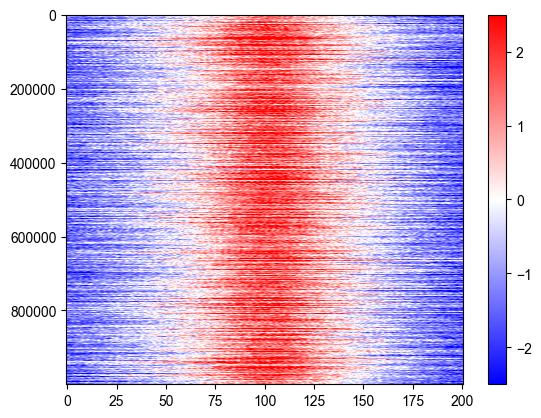

In [803]:
plt.figure()
plt.imshow(eclip_phyloP_Big_mat,aspect='auto',cmap=s_cmap,vmin=s_vmin,vmax=s_vmax,interpolation='bicubic')
plt.colorbar()
plt.savefig('colorbar.pdf')

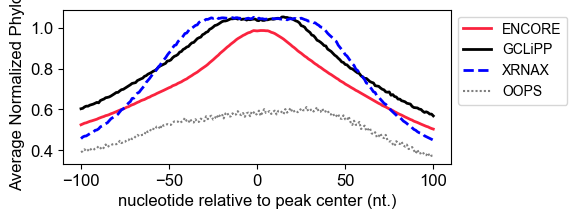

In [276]:
plt.figure(figsize=(5,2))



plt.plot(np.arange(len(eclip_not_norm_avg_curve))-100 ,eclip_not_norm_avg_curve ,linewidth=2,color='#FA233E',label='ENCORE')
plt.plot(np.arange(len(gclipp_not_norm_avg_curve))-100 ,gclipp_not_norm_avg_curve ,color='black',linewidth=2,label='GCLiPP')
plt.plot(np.arange(len(xrnax_not_norm_avg_curve))-100 ,xrnax_not_norm_avg_curve ,color='blue',linewidth=2,linestyle='--',label='XRNAX')
plt.plot(np.arange(len(oops_not_norm_avg_curve))-100 ,oops_not_norm_avg_curve ,color='black',linewidth=1.5,linestyle=(0, (1, 1)),label='OOPS',alpha=0.5)
plt.legend(fontsize=10,bbox_to_anchor=(1, 1) )

#plt.yticks([-1,0,1])
plt.xticks([-100,-50,0,50,100])
plt.xlabel('nucleotide relative to peak center (nt.)')
plt.ylabel('Average Normalized PhyloP')

plt.savefig('peak_averages.pdf')

In [281]:
np.std(gclipp_avg_curve)

1.0

In [229]:
(np.std(gclipp_avg_curve)**2)/(np.std(eclip_avg_curve)**2)

1.0000000000000004

In [230]:
(np.std(xrnax_avg_curve)**2)/(np.std(eclip_avg_curve)**2)

1.0000000000000002

In [231]:
(np.std(oops_avg_curve)**2)/(np.std(eclip_avg_curve)**2)

1.0000000000000004

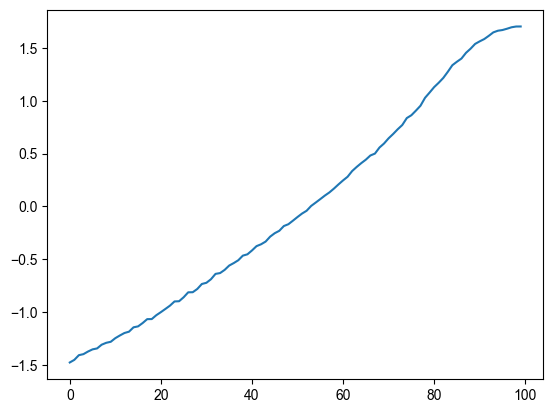

In [311]:
plt.plot((np.flip(eclip_avg_curve[100:200]) + eclip_avg_curve[:100])/2)

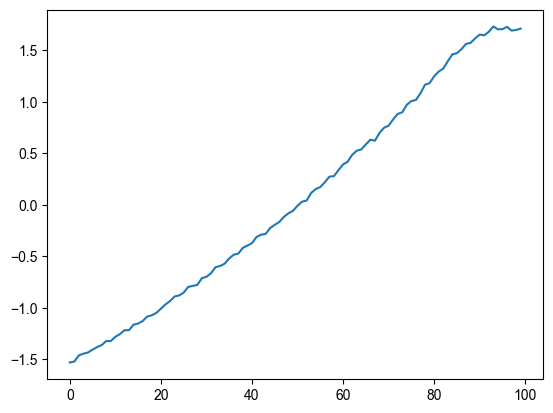

In [321]:
plt.plot(np.flip(eclip_avg_curve[100:200]))

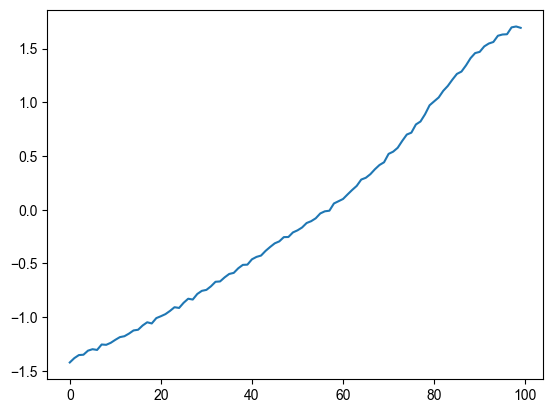

In [324]:
plt.plot(eclip_avg_curve[:100])

In [336]:
from scipy import stats
import scipy

In [782]:
#scipy.stats.chisquare(eclip_not_norm_avg_curve/sum(eclip_not_norm_avg_curve),f_exp= gclipp_not_norm_avg_curve/sum(gclipp_not_norm_avg_curve))



In [783]:
#scipy.stats.chisquare(eclip_not_norm_avg_curve/sum(eclip_not_norm_avg_curve),f_exp= xrnax_not_norm_avg_curve/sum(xrnax_not_norm_avg_curve))




In [784]:
#scipy.stats.chisquare(eclip_not_norm_avg_curve/sum(eclip_not_norm_avg_curve),f_exp= oops_not_norm_avg_curve/sum(oops_not_norm_avg_curve))


In [785]:
from scipy.stats import ttest_ind


In [701]:
A = gclipp_avg_curve
B = xrnax_avg_curve 
C = eclip_avg_curve

In [440]:
A = gclipp_not_norm_avg_curve
B = xrnax_not_norm_avg_curve 
C = eclip_not_norm_avg_curve

In [786]:
import numpy as np
import scipy.stats as stats
 
    
    
model_A_C = LinearRegression().fit(A.reshape(-1, 1), C)
residuals_A_C = C - model_A_C.predict(A.reshape(-1, 1))

model_B_C = LinearRegression().fit(B.reshape(-1, 1), C)
residuals_B_C = C - model_B_C.predict(B.reshape(-1, 1))

# Create the data for two groups
group1 = residuals_A_C
group2 = residuals_B_C
 
# Calculate the sample variances
variance1 = np.var(group1, ddof=1)
variance2 = np.var(group2, ddof=1)
 
# Calculate the F-statistic
f_value = variance2/variance1
 
# Calculate the degrees of freedom
df1 = len(group1) - 1
df2 = len(group2) - 1
 
# Calculate the p-value
p_value = 1-stats.f.cdf(f_value, df1, df2)
 
# Print the results
print('Degree of freedom 1:',df1)
print('Degree of freedom 2:',df2)
print("F-statistic:", f_value)
print("p-value:", p_value)

Degree of freedom 1: 200
Degree of freedom 2: 200
F-statistic: 3.13156902502
p-value: 1.99840144433e-15


R^2: 0.970732980697
-Log(P): 76.2359153783


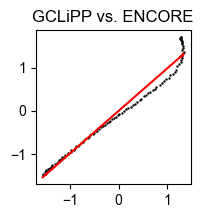

In [787]:
plt.figure(figsize=(2,2))
plt.style.use('default') 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 10
plt.rcParams["font.style"] = 'normal'
plt.rcParams["font.weight"] = 'normal'
plt.scatter((np.flip(gclipp_avg_curve[100:200]) + gclipp_avg_curve[:100])/2,(np.flip(eclip_avg_curve[100:200]) + eclip_avg_curve[:100])/2,s=0.5,c='black')
slope, intercept, r, p, std_err = stats.linregress((np.flip(gclipp_avg_curve[100:200]) + gclipp_avg_curve[:100])/2,(np.flip(eclip_avg_curve[100:200]) + eclip_avg_curve[:100])/2)
plt.plot((np.flip(gclipp_avg_curve[100:200]) + gclipp_avg_curve[:100])/2,(((np.flip(gclipp_avg_curve[100:200]) + gclipp_avg_curve[:100])/2)*slope)+intercept,c='red')
plt.title('GCLiPP vs. ENCORE')

print('R^2: ' + str((r**2)))
print('-Log(P): ' + str(-1*np.log10(p)))

plt.yticks([-1,0,1])
plt.savefig('EvsG.pdf')

In [788]:
gclipp_predictor = (np.flip(gclipp_avg_curve[100:200]) + gclipp_avg_curve[:100])/2
encore_predictor = (np.flip(eclip_avg_curve[100:200]) + eclip_avg_curve[:100])/2
gclipp_vs_E_residuals = encore_predictor- ((gclipp_predictor*slope)+intercept)

In [789]:
np.var(gclipp_vs_E_residuals)

0.028840802988418731

R^2: 0.890505793628
-Log(P): 48.1399657635


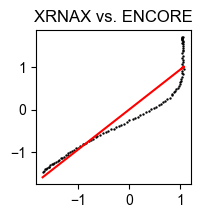

In [790]:
plt.figure(figsize=(2,2))
plt.style.use('default') 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 10
plt.rcParams["font.style"] = 'normal'
plt.rcParams["font.weight"] = 'normal'

plt.scatter((np.flip(xrnax_avg_curve[100:200]) + xrnax_avg_curve[:100])/2, (np.flip(eclip_avg_curve[100:200]) + eclip_avg_curve[:100])/2,s=0.5,c='black')
slope, intercept, r, p, std_err = stats.linregress((np.flip(xrnax_avg_curve[100:200]) + xrnax_avg_curve[:100])/2, (np.flip(eclip_avg_curve[100:200]) + eclip_avg_curve[:100])/2)
plt.plot((np.flip(xrnax_avg_curve[100:200]) + xrnax_avg_curve[:100])/2,(((np.flip(xrnax_avg_curve[100:200]) + xrnax_avg_curve[:100])/2)*slope)+intercept,c='red')
plt.title('XRNAX vs. ENCORE')

print('R^2: ' + str((r**2)))
print('-Log(P): ' + str(-1*np.log10(p)))

plt.yticks([-1,0,1])

plt.savefig('EvsX.pdf')

In [791]:
xrnax_predictor = (np.flip(xrnax_avg_curve[100:200]) + xrnax_avg_curve[:100])/2
xrnax_vs_E_residuals = encore_predictor- ((xrnax_predictor*slope)+intercept)

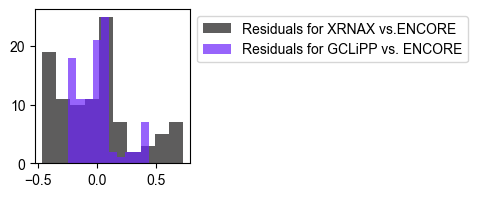

In [792]:
plt.figure(figsize=(2,2))
plt.style.use('default') 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 10   
plt.rcParams["font.style"] = 'normal'
plt.rcParams["font.weight"] = 'normal'

plt.hist(xrnax_vs_E_residuals,bins=10,label='Residuals for XRNAX vs.ENCORE',alpha=0.7,color='#1a1919',histtype='stepfilled')
plt.hist(gclipp_vs_E_residuals,bins=10, label='Residuals for GCLiPP vs. ENCORE',alpha=0.7,color='#6b23fa',histtype='stepfilled')
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('residplot_XvG.pdf')

In [793]:
df1, df2

(200, 200)

In [794]:
f_value = np.var(xrnax_vs_E_residuals)/np.var(gclipp_vs_E_residuals)
 
# Calculate the degrees of freedom
df1 = len(gclipp_vs_E_residuals) - 1
df2 = len(xrnax_vs_E_residuals) - 1
 
# Calculate the p-value
p_value = 1-stats.f.cdf(f_value, df1, df2)
f_value,-np.log10(p_value)

(3.741214820579835, 9.9152208675886797)

R^2: 0.847547285627
-Log(P): 41.0860177053


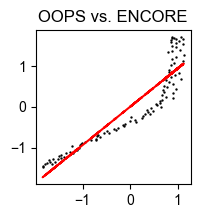

In [795]:
plt.figure(figsize=(2,2))
plt.style.use('default') 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 10
plt.rcParams["font.style"] = 'normal'
plt.rcParams["font.weight"] = 'normal'

plt.scatter((np.flip(oops_avg_curve[100:200]) + oops_avg_curve[:100])/2,(np.flip(eclip_avg_curve[100:200]) + eclip_avg_curve[:100])/2,s=0.5,c='black')
slope, intercept, r, p, std_err = stats.linregress((np.flip(oops_avg_curve[100:200]) + oops_avg_curve[:100])/2, (np.flip(eclip_avg_curve[100:200]) + eclip_avg_curve[:100])/2)
plt.plot((np.flip(oops_avg_curve[100:200]) + oops_avg_curve[:100])/2,(((np.flip(oops_avg_curve[100:200]) + oops_avg_curve[:100])/2)*slope)+intercept,c='red')
plt.title('OOPS vs. ENCORE')

print('R^2: ' + str((r**2)))
print('-Log(P): ' + str(-1*np.log10(p)))

plt.yticks([-1,0,1])
plt.savefig('EvsO.pdf')

In [796]:
oops_predictor = (np.flip(oops_avg_curve[100:200]) + oops_avg_curve[:100])/2
oops_vs_E_residuals = encore_predictor- ((oops_predictor*slope)+intercept)

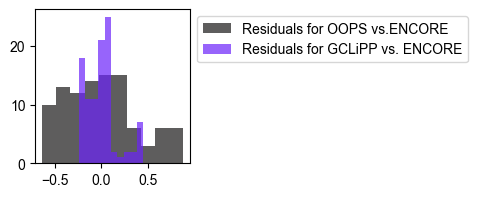

In [797]:
plt.figure(figsize=(2,2))
plt.style.use('default') 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 10   
plt.rcParams["font.style"] = 'normal'
plt.rcParams["font.weight"] = 'normal'

plt.hist(oops_vs_E_residuals,bins=10,label='Residuals for OOPS vs.ENCORE',alpha=0.7,color='#1a1919',histtype='stepfilled')
plt.hist(gclipp_vs_E_residuals,bins=10, label='Residuals for GCLiPP vs. ENCORE',alpha=0.7,color='#6b23fa',histtype='stepfilled')
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('residplot_OvG.pdf')

In [798]:
f_value = np.var(oops_vs_E_residuals)/np.var(gclipp_vs_E_residuals)
 
# Calculate the degrees of freedom
df1 = len(gclipp_vs_E_residuals) - 1
df2 = len(xrnax_vs_E_residuals) - 1
 
# Calculate the p-value
p_value = 1-stats.f.cdf(f_value, df1, df2)
f_value,-np.log10(p_value)

(5.2090277042634492, 14.46322807635673)

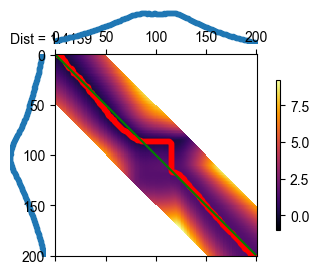

In [192]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
import numpy as np



d, paths = dtw.warping_paths(eclip_avg_curve,  gclipp_avg_curve, window=50, psi=2)
best_path = dtw.best_path(paths)

fig, ax = dtwvis.plot_warpingpaths(eclip_avg_curve,  gclipp_avg_curve, paths, best_path,showlegend=True)

fig.set_figheight(3)
fig.set_figwidth(3)
ax[3].plot(np.arange(200),np.arange(200), c='green')
plt.set_cmap("inferno")
plt.savefig('DTW_EvG.pdf')

In [185]:
dtwvis.plot_warpingpaths??

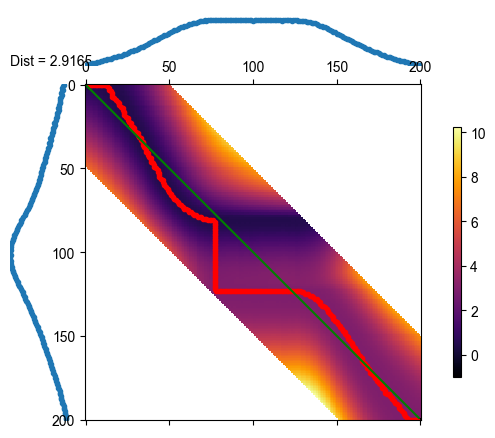

In [196]:

d, paths = dtw.warping_paths(eclip_avg_curve,  xrnax_avg_curve, window=50, psi=2)
best_path = dtw.best_path(paths)
fig, ax = dtwvis.plot_warpingpaths(eclip_avg_curve,  xrnax_avg_curve, paths, best_path,showlegend=True)
fig.set_figheight(5)
fig.set_figwidth(5)
plt.set_cmap("inferno")
ax[3].plot(np.arange(200),np.arange(200), c='green')
plt.savefig('DTW_EvX.pdf')

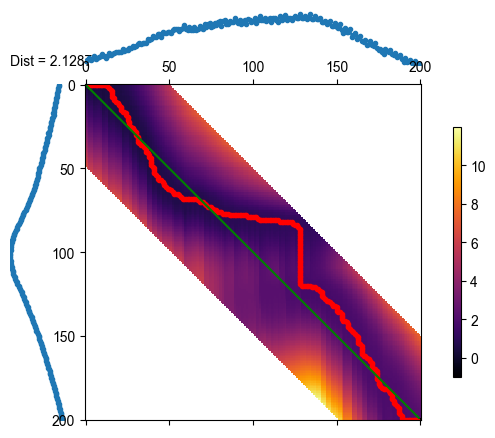

In [195]:
d, paths = dtw.warping_paths(eclip_avg_curve,  oops_avg_curve, window=50, psi=2)
best_path = dtw.best_path(paths)
fig, ax = dtwvis.plot_warpingpaths(eclip_avg_curve,  oops_avg_curve, paths, best_path,showlegend=True)
fig.set_figheight(5)
fig.set_figwidth(5)
plt.set_cmap("inferno")
ax[3].plot(np.arange(200),np.arange(200), c='green')

plt.savefig('DTW_EvO.pdf')

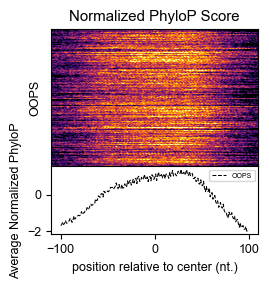

In [134]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns 
from matplotlib import pyplot
plt.style.use('default') 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 9
plt.rcParams["font.style"] = 'normal'
plt.rcParams["font.weight"] = 'normal'

fig = plt.figure(figsize=(4/1.5, 4/1.5))
gs = fig.add_gridspec(nrows=3, ncols=2,hspace=0.01)


ax_top = fig.add_subplot(gs[:2, :])
ax_top.set_title('Normalized PhyloP Score')
ax_top.imshow(oops_phyloP_Big_mat,aspect='auto',cmap='inferno',vmin=-3,vmax=3,interpolation='bicubic')
ax_top.set_ylabel('OOPS')

ax_top.set_yticks([])
ax_top.set_xticks([])



ax_right_bottom = fig.add_subplot(gs[-1, :])


ax_right_bottom.plot(np.arange(len(oops_avg_curve))-100 ,oops_avg_curve ,color='black',linewidth=0.75,linestyle='--',label='OOPS')
ax_right_bottom.set_xlabel("position relative to center (nt.)")
ax_right_bottom.set_ylabel("Average Normalized PhyloP")

ax_right_bottom.set_xticks([-100,0,100])
ax_right_bottom.legend(fontsize=5)

plt.savefig('plot2.pdf')

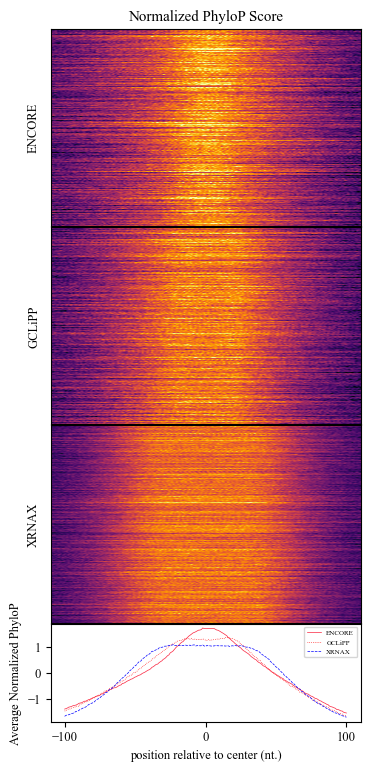

In [66]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns 
from matplotlib import pyplot
plt.style.use('default') 
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 9
plt.rcParams["font.style"] = 'normal'
plt.rcParams["font.weight"] = 'normal'

fig = plt.figure(figsize=(4, 9))
gs = fig.add_gridspec(nrows=7, ncols=2,hspace=0.01)


ax_top = fig.add_subplot(gs[:2, :])
ax_top.set_title('Normalized PhyloP Score')
ax_top.imshow(eclip_phyloP_Big_mat,aspect='auto',cmap='inferno',vmin=-3,vmax=3,interpolation='bicubic')
ax_top.set_ylabel('ENCORE')

ax_top.set_yticks([])
ax_top.set_xticks([])


ax_mid = fig.add_subplot(gs[2:4, :])
ax_mid.imshow(gclipp_phyloP_Big_mat,aspect='auto',cmap='inferno',vmin=-3,vmax=3,interpolation='bicubic')
ax_mid.set_ylabel('GCLiPP')

ax_mid.set_yticks([])
ax_mid.set_xticks([])


ax_last = fig.add_subplot(gs[4:6, :])
ax_last.imshow(xrnax_phyloP_Big_mat,aspect='auto',cmap='inferno',vmin=-3,vmax=3,interpolation='bicubic')
ax_last.set_ylabel('XRNAX')

ax_last.set_yticks([])
ax_last.set_xticks([])


ax_right_bottom = fig.add_subplot(gs[-1, :])


ax_right_bottom.plot(np.arange(len(eclip_avg_curve))-100 ,eclip_avg_curve ,linewidth=0.5,color='#FA233E',label='ENCORE')
ax_right_bottom.plot(np.arange(len(gclipp_avg_curve))-100 ,gclipp_avg_curve ,color='red',linewidth=0.5,linestyle='dotted',label='GCLiPP')
ax_right_bottom.plot(np.arange(len(xrnax_avg_curve))-100 ,xrnax_avg_curve ,color='blue',linewidth=0.5,linestyle='--',label='XRNAX')

ax_right_bottom.set_xlabel("position relative to center (nt.)")
ax_right_bottom.set_ylabel("Average Normalized PhyloP")

ax_right_bottom.set_xticks([-100,0,100])
ax_right_bottom.legend(fontsize=5)

# Old Analysis Below

In [4]:
xrnax = pd.read_csv('Resources/Clipper_Peaks/ERR2537872_10t_sorted_picard_clipper_2.0.bed', sep="\t", header=None)
xrnax.columns = ["chrom", "start", "stop","id", "v1", "strands", "v2", "v3"]
xrnax = (xrnax[['chrom','start','stop','strands']])
xrnax = xrnax.to_numpy()

filename,show_tqdm="Resources/hg38.phyloP100way.bw",False
xrnax_p100 = multi_p(xrnax)

filename,show_tqdm="Resources/hg38.phyloP20way.bw",False
xrnax_p20 = multi_p(xrnax)

filename,show_tqdm="Resources/hg38.phyloP7way.bw",False
xrnax_p7 = multi_p(xrnax)

del xrnax

Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Total Runtime: 10.3 seconds
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Total Runtime: 9.8 seconds
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Total Runtime: 9.04 seconds


In [5]:
oops = pd.read_csv('Resources/Clipper_Peaks/275_sorted_de_dup.bed', sep="\t", header=None)
oops.columns = ["chrom", "start", "stop","id", "v1", "strands", "v2", "v3"]
oops = (oops[['chrom','start','stop','strands']])
oops = oops.to_numpy()

filename,show_tqdm="Resources/hg38.phyloP100way.bw",False
oops_p100 = multi_p(oops)

filename,show_tqdm="Resources/hg38.phyloP20way.bw",False
oops_p20 = multi_p(oops)

filename,show_tqdm="Resources/hg38.phyloP7way.bw",False
oops_p7 = multi_p(oops)

del oops

Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0Fails: 0

Fails: 0
Fails: 0
Fails: 0
Total Runtime: 1.53 seconds
Fails: 0
Fails: 0
Fails: 0
Fails: 0Fails: 0

Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Total Runtime: 1.43 seconds
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Total Runtime: 1.21 seconds


In [6]:
eclip = pd.read_csv('Resources/Clipper_Peaks/all_eclip_peaks.txt', sep="\t", header=None)
eclip.columns = ["chrom", "start", "stop","id", "v1", "strands", "v2", "v3", "v4", "v5"]
eclip = (eclip[['chrom','start','stop','strands']])
eclip = eclip.to_numpy()

filename,show_tqdm="Resources/hg38.phyloP100way.bw",False
eclip_p100 = multi_p(eclip)

filename,show_tqdm="Resources/hg38.phyloP20way.bw",False
eclip_p20 = multi_p(eclip)

filename,show_tqdm="Resources/hg38.phyloP7way.bw",False
eclip_p7 = multi_p(eclip)

del eclip

Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 4399
Total Runtime: 213.6 seconds
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 4399
Fails: 0
Total Runtime: 196.87 seconds
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 4399
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Total Runtime: 182.79 seconds


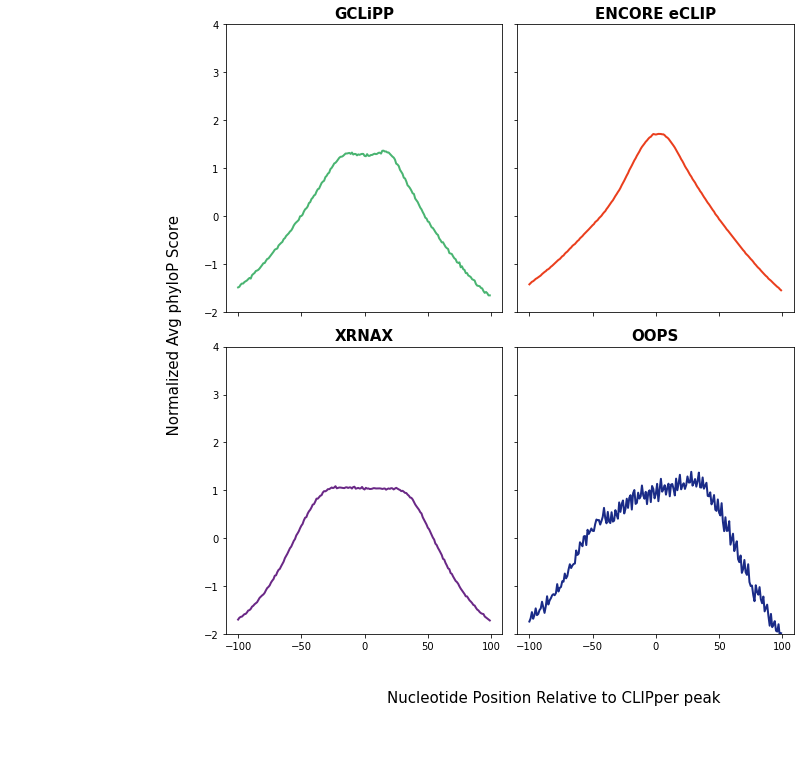

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(9,10), sharex=True, sharey=True)
axs[0,0].plot(np.arange(200)-100, normalize(gclipp_p100[:200]),label="phyloP100way",c=(73/255, 180/255, 113/255),linewidth=2.0)
axs[0,0].set_title('GCLiPP',fontsize=15,fontweight='bold')


axs[0,1].plot(np.arange(200)-100, normalize(eclip_p100[:200]),label="phyloP100way",c=(234/255, 62/255, 29/255),linewidth=2.0)
axs[0,1].set_title('ENCORE eCLIP',fontsize=15,fontweight='bold')



axs[1,0].plot(np.arange(200)-100, normalize(xrnax_p100[:200]),label="phyloP100way",c=(106/255, 40/255, 134/255),linewidth=2.0)
axs[1,0].set_title('XRNAX',fontsize=15,fontweight='bold')



axs[1,1].plot(np.arange(200)-100, normalize(oops_p100[:200]),label="phyloP100way",c=(26/255, 43/255, 135/255),linewidth=2.0)
axs[1,1].set_title('OOPS',fontsize=15,fontweight='bold')
axs[1,1].set_ylim(-2,4)



axs[1,0].set_ylabel((" "*70)+'Normalized Avg phyloP Score\n',fontsize=15)
axs[1,0].set_xlabel('\n\n'+(" "*80)+'Nucleotide Position Relative to CLIPper peak',fontsize=15)
plt.xticks([-100,-50,0,50,100])

plt.tight_layout()
plt.savefig('Plot-v1.pdf')

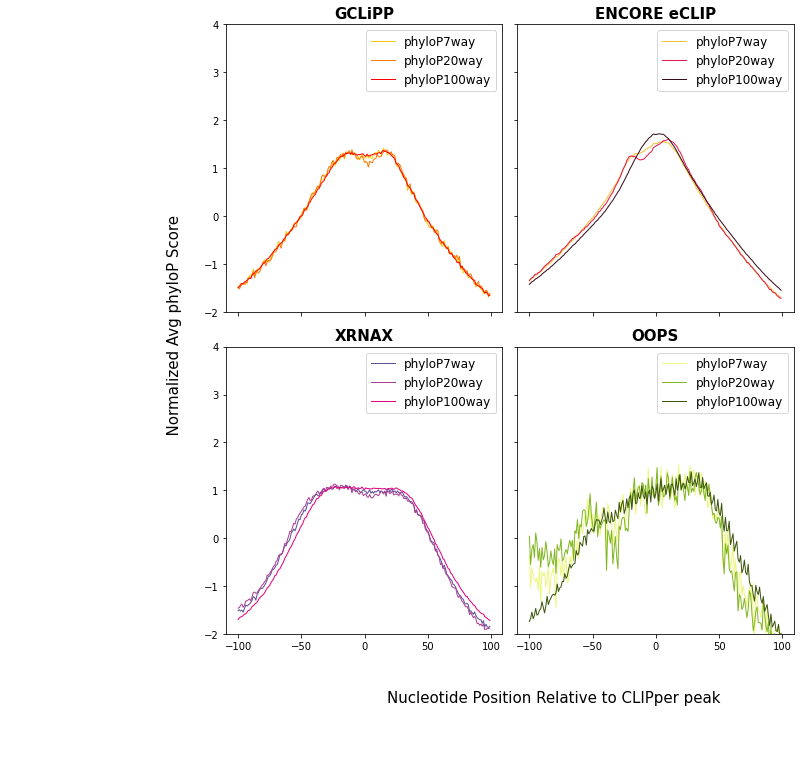

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(9,10),sharex=True, sharey=True)
axs[0,0].plot(np.arange(200)-100, normalize(gclipp_p7[:200]),label="phyloP7way",c='#f9c706',linewidth=1.0)
axs[0,0].plot(np.arange(200)-100, normalize(gclipp_p20[:200]),label="phyloP20way",c='#fa7b03',linewidth=1.0)
axs[0,0].plot(np.arange(200)-100, normalize(gclipp_p100[:200]),label="phyloP100way",c='#ff0101',linewidth=1.0)
axs[0,0].set_title('GCLiPP',fontsize=15,fontweight='bold')
axs[0,0].legend(fontsize=12)

axs[0,1].plot(np.arange(200)-100, normalize(eclip_p7[:200]),label="phyloP7way",c='#f1c232',linewidth=1.0)
axs[0,1].plot(np.arange(200)-100, normalize(eclip_p20[:200]),label="phyloP20way",c='#e2194b',linewidth=1.0)
axs[0,1].plot(np.arange(200)-100, normalize(eclip_p100[:200]),label="phyloP100way",c='#350d17',linewidth=1.0)
axs[0,1].set_title('ENCORE eCLIP',fontsize=15,fontweight='bold')
axs[0,1].legend(fontsize=12)


axs[1,0].plot(np.arange(200)-100, normalize(xrnax_p7[:200]),label="phyloP7way",c='#5e4e9c',linewidth=1.0)
axs[1,0].plot(np.arange(200)-100, normalize(xrnax_p20[:200]),label="phyloP20way",c='#ab3e8f',linewidth=1.0)
axs[1,0].plot(np.arange(200)-100, normalize(xrnax_p100[:200]),label="phyloP100way",c='#e5007d',linewidth=1.0)
axs[1,0].set_title('XRNAX',fontsize=15,fontweight='bold')
axs[1,0].legend(fontsize=12)


axs[1,1].plot(np.arange(200)-100, normalize(oops_p7[:200]),label="phyloP7way",c='#ECF87F',linewidth=1.0)
axs[1,1].plot(np.arange(200)-100, normalize(oops_p20[:200]),label="phyloP20way",c='#81B622',linewidth=1.0)
axs[1,1].plot(np.arange(200)-100, normalize(oops_p100[:200]),label="phyloP100way",c='#3D550C',linewidth=1.0)
axs[1,1].set_title('OOPS',fontsize=15,fontweight='bold')
axs[1,1].legend(fontsize=12)
axs[1,1].set_ylim(-2,4)

axs[1,0].set_ylabel((" "*70)+'Normalized Avg phyloP Score\n',fontsize=15)
axs[1,0].set_xlabel('\n\n'+(" "*80)+'Nucleotide Position Relative to CLIPper peak',fontsize=15)

plt.xticks([-100,-50,0,50,100])
plt.tight_layout()
plt.savefig('Plot-v2.pdf')